# Node Classification with Neural Networks and Graph Neural Networks

Based on the Keras guide in https://keras.io/examples/graph/gnn_citations/

In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import re
from matplotlib_venn import venn3
from scipy import stats


## Prepare the Data

### Load the datasets

In [2]:
# Move out of the notebook folder to access datasets
working_dir = os.getcwd()
working_dir = working_dir.strip('notebooks')
data_dir = working_dir + 'data/PROTECTED_DATA/BGI_Expression_Data/'


## Load Transcriptomics Data 
transcriptomics_TPM_dataset_dir = data_dir + 'CRC.SW.mRNA.symbol.TPM_NOnormal.csv'  
transcriptomics_dataset = pd.read_csv(transcriptomics_TPM_dataset_dir, index_col=0)

# Classification Tags
labels_classification_dir = data_dir + 'ClassTags_PrimarySiteDisease.csv' # Using only tumor samples
labels = pd.read_csv(labels_classification_dir, index_col=0)


# Figures Saving output dir


# Convert The directory to the name of the column
trait_used_as_label = labels_classification_dir.replace(data_dir, '').replace('ClassTags_', '').replace('.csv', '')
trait_used_as_label = re.sub(r'(?<=\w)([A-Z])', r' \1', trait_used_as_label) # Add spaces before the capital letters for formatting

# Convert labels to categorical values
#class_values = labels[trait_used_as_label].astype('category').cat.codes
#labels['label'] = class_values


### Explore distribution and balance of the dataset

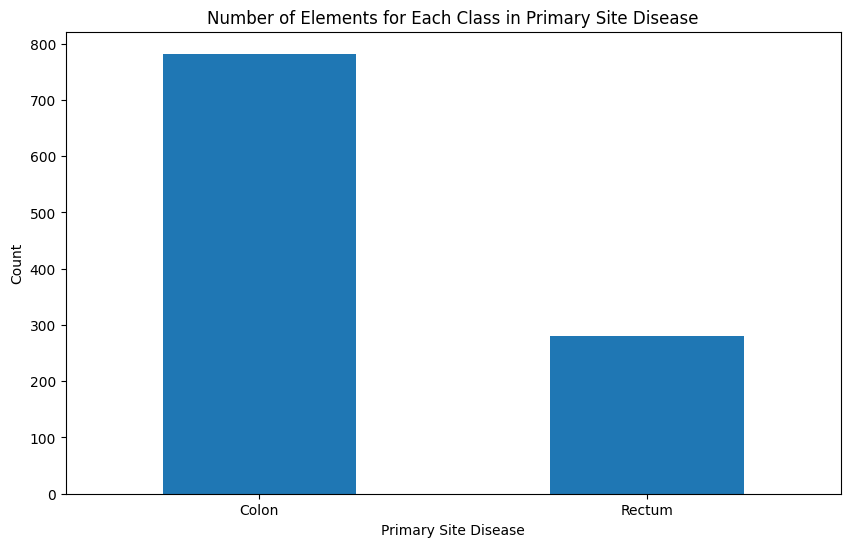

In [3]:
class_counts = labels[trait_used_as_label].value_counts()

# Plotting a histogram of class distribution
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title(f'Number of Elements for Each Class in {trait_used_as_label}')
plt.xlabel(trait_used_as_label)
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

### Build dummified Dataframe for NN

In [4]:
## Merge the Labels column (with the selected clinical trail) with the transcriptomics dataset
transcriptomics_labeled_df = pd.merge(left=transcriptomics_dataset, left_index=True, right=labels, right_index=True, how='inner')


## We convert the Samples ids and the Labels into zero-based indices.
class_values = labels[trait_used_as_label].unique()
class_idx = {name: id for id, name in enumerate(class_values)}
pacient_idx = {name: idx for idx, name in enumerate(transcriptomics_dataset.index.unique())}


## We update the dataframe with this dummified values
transcriptomics_labeled_df = transcriptomics_labeled_df.rename(index=pacient_idx)
transcriptomics_labeled_df[trait_used_as_label] = transcriptomics_labeled_df[trait_used_as_label].apply(lambda name: class_idx[name])
transcriptomics_labeled_df

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,AC118549.1,Primary Site Disease
Sample_ID,,,,,,,,,,,,,,,,,,,,,
0,0.59,17.19,699.63,0.01,0.00,13.53,0.00,57.57,25.34,0.00,...,58.35,6.80,15.53,38.82,0.11,31.47,173.78,33.11,17.82,0
1,0.15,22.14,271.97,0.04,0.00,11.63,0.05,33.48,24.24,0.10,...,42.61,6.82,14.28,40.58,0.04,19.97,220.88,50.81,12.90,1
2,0.75,23.09,221.77,0.01,0.00,6.85,0.10,55.10,30.44,0.83,...,45.46,10.10,26.16,39.23,0.00,21.66,198.96,35.81,16.74,1
3,0.14,10.17,521.99,0.13,0.00,11.68,0.00,42.44,16.39,0.15,...,17.89,9.91,21.18,33.81,0.15,23.25,208.30,26.46,23.62,1
4,0.14,7.18,123.65,0.05,0.00,10.36,0.00,39.44,17.00,1.49,...,19.59,4.74,9.74,25.59,0.15,11.26,249.54,17.84,13.08,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1058,0.00,18.61,118.94,0.03,0.00,5.55,0.00,56.81,38.55,0.21,...,73.63,7.70,15.27,31.68,0.07,23.80,218.57,47.53,19.17,1
1059,0.00,18.95,116.77,0.03,0.00,2.18,0.00,44.16,39.94,0.34,...,29.45,6.52,15.88,32.49,0.00,16.61,173.41,39.83,18.48,1
1060,0.00,20.27,33.46,0.15,0.19,5.10,0.00,31.81,32.55,4.53,...,31.58,6.70,14.93,27.05,0.04,12.46,130.34,27.31,14.83,0


### Split the dataset into stratified Train, Test and Validation sets


In [ ]:
train_data, test_data, validation_data = [], [], []

# Create train and test splits
for _, group_data in transcriptomics_labeled_df.groupby(trait_used_as_label):
    # Declare the % of train, test, validate
    train_split = 0.7
    test_split = 0.2
    
    # Build the subsets for each category
    random_selection = np.random.rand(len(group_data.index))
    train_subset = random_selection <= train_split
    test_subset = (random_selection > train_split) & (random_selection <= (train_split + test_split))
    val_subset = random_selection > (train_split + test_split)

    # Reformat the data
    train_data.append(group_data[train_subset])
    test_data.append(group_data[test_subset])
    validation_data.append(group_data[val_subset])

# Concatenate and shuffle the subsets from each group
train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)
validation_data = pd.concat(validation_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)
print("Validation data shape:", validation_data.shape)


# Plot Venn diagram to visualize overlap
venn3([set(train_data.index), set(test_data.index), set(validation_data.index)], ('Train', 'Test', 'Validation'))
plt.title("Overlap between Train, Test, and Validation Sets")
plt.show()

### Prepare the data for the NN

In [ ]:
## Get the genes's names, removing the label column
feature_names = list(set(transcriptomics_labeled_df.columns) - {trait_used_as_label})
num_features = len(feature_names)
num_classes = len(class_idx)

## Create train,test and validation features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
x_validation = validation_data[feature_names].to_numpy()

## Create train and test targets as a numpy array.
y_train = train_data[trait_used_as_label]
y_test = test_data[trait_used_as_label]
y_validation = validation_data[trait_used_as_label]

## Implement Train and Evaluate Functions

Hyperparameter configuration - Standard values

In [ ]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

These functions compiles and trains an input model using the given training data, displays the loss and accuracy curves, and Implement Feedforward Network (FFN) Module

In [ ]:
def run_training(model, x_train, y_train, x_test, y_test):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_data=(x_test, y_test),
        callbacks=[early_stopping],
    )

    return history

def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

## Build a Baseline Neural Network Model

### Implement a baseline classifier

In [ ]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

### Train the baseline classifier

In [ ]:
## Train the model
history = run_training(baseline_model, x_train, y_train, x_test, y_test)

display_learning_curves(history)

### Evaluate on Validation data

In [ ]:
## Evaluate the baseline model on the VALIDATION data split. 
_, test_accuracy = baseline_model.evaluate(x=x_validation, y=y_validation, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

# Build a Graph Neural Network Model


### Build a Graph from the data, to feed it to the GNN

For this example, we will use the simplest approach to this, that it consists on building a simple correlation matrix between the pacients, and not the genes.
This approach shall be improved in further version


In [ ]:
## In this architecutre, each node is a pacient, and the node features is the full transcriptome of that pacient [num_nodes, num_features]
node_features = tf.cast(transcriptomics_labeled_df[feature_names].to_numpy(), dtype=tf.dtypes.float32) # We keep the label out!!



## The links will be the correlation between pacients, and the weight the strength of the correlation
# Turn dataframe into NumPy matrix for efficiency
transcriptomics_np = transcriptomics_labeled_df.to_numpy()

# Calculate Correlation matrix (correlation between pacients)
pacients_correlation_matrix, _ = stats.spearmanr(transcriptomics_np, axis=1)

# Normalize edge weights and adjust self-connections
pacients_correlation_matrix = (pacients_correlation_matrix + 1) / 2
np.fill_diagonal(pacients_correlation_matrix, 0)
pacients_correlation_matrix = np.clip(pacients_correlation_matrix, 0, 1)

# Flatten the correlation matrix (only upper half) (excluding the diagonal (k=1))
rows, cols = np.triu_indices(n=pacients_correlation_matrix.shape[0], k=1)
flat_edge_weights = pacients_correlation_matrix[rows, cols]
edge_weights = tf.constant(flat_edge_weights, dtype=tf.float32)



## Create the edges array
edges = np.vstack((rows, cols))


# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)


# Display shapes of node_features and edge_weights
print("Node Features shape:", node_features.shape)
print("Edges shape:", edges.shape)
print("Edge Weights shape:", edge_weights.shape)

### Implement a graph convolution layer


In [ ]:

def create_gru(hidden_units, dropout_rate):
    inputs = keras.layers.Input(shape=(2, hidden_units[0]))
    x = inputs
    for units in hidden_units:
      x = layers.GRU(
          units=units,
          activation="tanh",
          recurrent_activation="sigmoid",
          return_sequences=True,
          dropout=dropout_rate,
          return_state=False,
          recurrent_dropout=dropout_rate,
      )(x)
    return keras.Model(inputs=inputs, outputs=x)


class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gru":
            self.update_fn = create_gru(hidden_units, dropout_rate)
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        # node_repesentations shape is [num_nodes, representation_dim].
        num_nodes = node_repesentations.shape[0]
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)


### Implement a graph neural network node classifier


In [ ]:

class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)


### Create and summary of the GNN

In [ ]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100]))

gnn_model.summary()

### Train and Display Learning Curves for the GNN model

In [ ]:
## Train the model
x_train = train_data.index.to_numpy()
x_test = test_data.index.to_numpy()

history = run_training(gnn_model, x_train, y_train, x_test, y_test)

display_learning_curves(history)



### Evaluate on Validation data

In [ ]:
x_validation = validation_data.index.to_numpy()

_, test_accuracy = gnn_model.evaluate(x=x_validation, y=y_validation, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")